In [82]:
import pandas as pd
import numpy as np

import requests

import os
import time
from datetime import datetime
import sys
import yaml
import gc


from data_loader import *
from utils import *
from nn import *
from models import *


import seaborn as sns
sns.set_style("darkgrid")
plt.rcParams.update({
    'axes.facecolor': '#1e1e1e',
    'figure.facecolor': '#1e1e1e',
    'axes.edgecolor': 'white',
    'axes.labelcolor': 'white',
    'xtick.color': 'white',
    'ytick.color': 'white',
    'text.color': 'white',
    'axes.grid': True,
    'grid.color': 'gray'
})

pd.set_option("display.max_column",None)
print(os.getcwd())


%load_ext autoreload
%reload_ext autoreload
%autoreload 2


def auto_reload():
    %load_ext autoreload
    %reload_ext autoreload
    %autoreload 2

/Users/echhitjoshi/Library/Mobile Documents/com~apple~CloudDocs/Work/overperformXG/app
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
with open("config.yaml",'r') as f:
    config = yaml.safe_load(f)

home_dir = config['HOME_DIRECTORY']
home_dir

'/Users/echhitjoshi/Library/Mobile Documents/com~apple~CloudDocs/Work/overperformXG'

In [3]:
# Model File Configs:
# Every Run of the notebook is logged in to a submodel folder for it

############################################################################
# Please set output path to the project directory where it is uncompressed #
############################################################################

project_path = home_dir + "/outputs/models/"




output_path = ""

submodel_name = ""

encoding_path = ""
feature_report_path = ""
def create_submodel(model_name:str):
    author = "EJ"
    global submodel_name
    submodel_name = datetime.now().strftime("%d_%H_%M") + "_"+model_name
    global output_path
    output_path = project_path+submodel_name
    global encoding_path
    encoding_path = output_path+"/encodings/"
    global feature_report_path
    feature_report_path = output_path+"/feature_report/"
    os.mkdir(output_path)
    os.mkdir(encoding_path)
    os.mkdir(feature_report_path)


In [4]:
create_submodel("test")

# API Football:
https://www.api-football.com

![PYTHON LOGO](https://www.api-football.com/public/img/news/archi-beta.jpg)

In [5]:
leagues_dat = get_leagues(home_dir +"/data/Leagues/leagues.parquet")
leagues_dat[['league_id','league_name','country_name']]

,league_id,league_name,country_name
0,4,Euro Championship,World
1,21,Confederations Cup,World
2,61,Ligue 1,France
3,144,Jupiler Pro League,Belgium
4,71,Serie A,Brazil
...,...,...,...
1128,1131,Super Cup,Mongolia
1129,1132,AFC Challenge League,World
1130,1133,Goiano - 3,Brazil
1131,1001,CONCACAF Women U20,World


# Leagues subset:

In [6]:
# Configs
major_leagues = ["Premier League","La Liga","Serie A","Bundesliga","Eredivisie","Ligue 1"]
major_countries = ["England","Spain","Italy","Germany","Netherlands","France","Brazil"]
teams = ["Liverpool","Wolves"] # teams to pull players data of
seasons = [2022,2021,2023,2024] # seasons to pull players and teams stats of



leagues_subset = leagues_dat[leagues_dat.league_name.isin(major_leagues) & leagues_dat.country_name.isin(major_countries)] # league ID to pull from, current values: {39:premier league}, Add to dictionary as needed

In [7]:
leagues_subset

,seasons,league_id,league_name,league_type,league_logo,country_name,country_code,country_flag
2,"[{'coverage': {'fixtures': {'events': True, 'l...",61,Ligue 1,League,https://media.api-sports.io/football/leagues/6...,France,FR,https://media.api-sports.io/flags/fr.svg
4,"[{'coverage': {'fixtures': {'events': True, 'l...",71,Serie A,League,https://media.api-sports.io/football/leagues/7...,Brazil,BR,https://media.api-sports.io/flags/br.svg
5,"[{'coverage': {'fixtures': {'events': True, 'l...",39,Premier League,League,https://media.api-sports.io/football/leagues/3...,England,GB,https://media.api-sports.io/flags/gb.svg
6,"[{'coverage': {'fixtures': {'events': True, 'l...",78,Bundesliga,League,https://media.api-sports.io/football/leagues/7...,Germany,DE,https://media.api-sports.io/flags/de.svg
7,"[{'coverage': {'fixtures': {'events': True, 'l...",135,Serie A,League,https://media.api-sports.io/football/leagues/1...,Italy,IT,https://media.api-sports.io/flags/it.svg
8,"[{'coverage': {'fixtures': {'events': True, 'l...",88,Eredivisie,League,https://media.api-sports.io/football/leagues/8...,Netherlands,NL,https://media.api-sports.io/flags/nl.svg
10,"[{'coverage': {'fixtures': {'events': True, 'l...",140,La Liga,League,https://media.api-sports.io/football/leagues/1...,Spain,ES,https://media.api-sports.io/flags/es.svg


# Read All fixtures data

In [8]:
teams_dat = pd.read_parquet(home_dir + "/data/Teams/team_league.parquet")

In [9]:
fixtures_dir = home_dir + "/data/Fixtures"

complete_data = pd.DataFrame()
for file in os.listdir(fixtures_dir):
    dat = pd.read_parquet(os.path.join(fixtures_dir,file))
    complete_data = pd.concat([complete_data,dat],axis = 0)

complete_data = complete_data.reset_index()
complete_data.drop(columns = ['index'],inplace=True)

/var/folders/x2/4jp5z9p56hd1r0cvzk8fb0200000gn/T/ipykernel_35263/1208416677.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  complete_data = pd.concat([complete_data,dat],axis = 0)
/var/folders/x2/4jp5z9p56hd1r0cvzk8fb0200000gn/T/ipykernel_35263/1208416677.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  complete_data = pd.concat([complete_data,dat],axis = 0)
/var/folders/x2/4jp5z9p56hd1r0cvzk8fb0200000gn/T/ipykernel_35263/1208416677.py:6: FutureWarning: The behavior of DataFrame concatena

In [22]:
# Data checks
complete_data['passes_accuracy'] = complete_data['passes_accuracy'].astype("float64")
complete_data['fixture_date'] = pd.to_datetime(complete_data.fixture_date)
complete_data = create_datetime_columns(complete_data,'fixture_date')

# Targets
complete_data['outcome_num'] = pd.Categorical(complete_data.outcome).codes

complete_data['win'] = np.where(complete_data.outcome.str.lower() == 'win', 1,0)


/Users/echhitjoshi/Library/Mobile Documents/com~apple~CloudDocs/Work/overperformXG/app/data_loader.py:47: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['month_e'] = data[dt_col].dt.to_period('M')
/Users/echhitjoshi/Library/Mobile Documents/com~apple~CloudDocs/Work/overperformXG/app/data_loader.py:51: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['week_e'] = data[dt_col].dt.to_period('W-MON')


In [25]:
complete_data[complete_data.fixture_date.notna()].shape

(76458, 61)

In [17]:
complete_data['fixture_date'].dt.year.value_counts()

fixture_date
2025.0    64011
2024.0    12156
Name: count, dtype: int64

In [26]:
complete_data.head()

,player_id,player_name,offsides,games_minutes,games_number,games_position,games_rating,games_captain,games_substitute,shots_total,shots_on,goals_total,goals_conceded,goals_assists,goals_saves,passes_total,passes_key,passes_accuracy,tackles_total,tackles_blocks,tackles_interceptions,duels_total,duels_won,dribbles_attempts,dribbles_success,dribbles_past,fouls_drawn,fouls_committed,cards_yellow,cards_red,penalty_won,penalty_commited,penalty_scored,penalty_missed,penalty_saved,fixture_id,team_goals_scored,team_non_penalty_goals_scored,team_goals_scored_half,team_goals_conceded,team_non_penalty_goals_conceded,team_goals_conceded_half,opponent,team_winner,team,outcome,dribble_success_rate,target_shot_conversion_perc,duels_won_perc,pass_accuracy_perc,fixture_date,outcome_num,win,major_position,major_position_ix,year_e,month_e,month_name_e,day_of_week_e,day_of_week_name_e,week_e
0,47269,Álex Remiro,NaN,90.0,1,G,6.2,False,False,NaN,NaN,NaN,2,0.0,2.0,31.0,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0,0,0.0,1208500,1,1.0,0,2,2.0,0,Rayo Vallecano,Rayo Vallecano,Real Sociedad,loss,NaN,NaN,NaN,83.870968,NaT,1,0,G,0.613627,NaN,NaT,NaN,NaN,NaN,NaT
1,2202,Hamari Traoré,NaN,75.0,18,D,6.9,False,False,NaN,NaN,NaN,0,0.0,NaN,37.0,NaN,30.0,2.0,NaN,NaN,8.0,5.0,1.0,1.0,1.0,NaN,NaN,0,0,NaN,NaN,0,0,NaN,1208500,1,1.0,0,2,2.0,0,Rayo Vallecano,Rayo Vallecano,Real Sociedad,loss,100.0,NaN,62.500000,81.081081,NaT,1,0,D,0.613891,NaN,NaT,NaN,NaN,NaN,NaT
2,47298,Aritz Elustondo,NaN,90.0,6,D,6.9,False,False,1.0,NaN,NaN,0,0.0,NaN,77.0,1.0,70.0,1.0,1.0,1.0,10.0,6.0,NaN,NaN,NaN,4.0,2.0,0,0,NaN,NaN,0,0,NaN,1208500,1,1.0,0,2,2.0,0,Rayo Vallecano,Rayo Vallecano,Real Sociedad,loss,NaN,NaN,60.000000,90.909091,NaT,1,0,D,0.613891,NaN,NaT,NaN,NaN,NaN,NaT
3,182546,Jon Pacheco,NaN,90.0,20,D,7.5,False,False,NaN,NaN,NaN,0,0.0,NaN,51.0,NaN,45.0,1.0,1.0,1.0,6.0,4.0,NaN,NaN,NaN,1.0,1.0,0,0,NaN,NaN,0,0,NaN,1208500,1,1.0,0,2,2.0,0,Rayo Vallecano,Rayo Vallecano,Real Sociedad,loss,NaN,NaN,66.666667,88.235294,NaT,1,0,D,0.613891,NaN,NaT,NaN,NaN,NaN,NaT
4,182636,Javi López,NaN,90.0,12,D,5.9,False,False,1.0,NaN,NaN,0,0.0,NaN,39.0,NaN,34.0,NaN,1.0,NaN,5.0,1.0,1.0,NaN,1.0,1.0,NaN,0,0,NaN,NaN,0,0,NaN,1208500,1,1.0,0,2,2.0,0,Rayo Vallecano,Rayo Vallecano,Real Sociedad,loss,NaN,NaN,20.000000,87.179487,NaT,1,0,D,0.613891,NaN,NaT,NaN,NaN,NaN,NaT


In [ ]:
# This is the dictionary that contains all information about the features    
dat_dict = find_data_types(complete_data,config['OUTCOME_COLS'] + ['outcome_num','outcome'])
dat_dict = pd.DataFrame(list(dat_dict.items()),columns =['feature','type'])

# differentiate modeling features
non_modeling_features = config['FIXTURE_COLS'] + config['OUTCOME_COLS'] + config['MISC_COLS'] + ['outcome_num','win','fixture_date','major_position']
dat_dict['modeling_feature'] = np.where(dat_dict['feature'].isin(non_modeling_features),0,1)
dat_dict['encoded'] = 0

print(dat_dict['type'].value_counts())
dat_dict.reset_index(drop= True)

## Encode Features
dat_dict = create_data_index(complete_data,dat_dict,'target',encoding_path)
dat_dict[dat_dict.modeling_feature ==1]

type
numeric        37
target         10
categorical     5
other           3
Name: count, dtype: int64


,feature,type,modeling_feature,encoded
2,offsides,numeric,1,0
9,shots_total,numeric,1,0
10,shots_on,numeric,1,0
11,goals_total,numeric,1,0
12,goals_conceded,numeric,1,0
13,goals_assists,numeric,1,0
14,goals_saves,numeric,1,0
15,passes_total,numeric,1,0
16,passes_key,numeric,1,0
17,passes_accuracy,numeric,1,0


In [19]:
# primary position map:
player_position = complete_data.groupby(["player_id","games_position"],as_index = False).agg(games_played = ("player_id","size"))
player_position['multiple_records'] = player_position.groupby('player_id')['games_played'].transform("cumsum")
player_position['multiple_records'] = player_position.groupby('player_id')['multiple_records'].transform("max")
player_position['major_position'] = np.where(player_position.games_played/player_position.multiple_records >= .5, player_position.games_position,None)
player_position_map = player_position[['player_id','major_position']].dropna().drop_duplicates()
player_position_map

# Join back to complete_data

complete_data = pd.merge(complete_data,player_position_map,on = 'player_id',how = 'left')

In [74]:
# quick knn clustering
from sklearn.cluster import KMeans

# who is ekitike most similar to 

interest_col_set = list(set(['major_position','player_id','player_name'] + config["ATTACK_COLS"] +  config["PASSING_COLS"]))


# primary position:



striker_stats = complete_data[interest_col_set].fillna(0)[complete_data[interest_col_set].fillna(0).major_position.isin(['F'])].groupby(['player_id','player_name'],as_index = False).agg(n_games = ('player_name','size'),
                                                                          avg_dribble_success = ('dribble_success_rate','mean'),
                                                                          std_dribble_success = ('dribble_success_rate','std'),
                                                                          avg_target_shot_cr = ('target_shot_conversion_perc','mean'),
                                                                          std_target_shot_cr = ('target_shot_conversion_perc','std'),
                                                                          avg_duels_cr = ('duels_won_perc','mean'),
                                                                          std_duels_cr = ('duels_won_perc','std'),
                                                                          avg_pass_accuracy = ('pass_accuracy_perc','mean'),
                                                                          std_pass_accuracy = ('pass_accuracy_perc','std')
                                                                          )


striker_stats = striker_stats[striker_stats.n_games > 40]
striker_stats.shape


(377, 11)

In [75]:
striker_stats.sort_values('avg_dribble_success',ascending=False)

,player_id,player_name,n_games,avg_dribble_success,std_dribble_success,avg_target_shot_cr,std_target_shot_cr,avg_duels_cr,std_duels_cr,avg_pass_accuracy,std_pass_accuracy
1159,350927,Henry Mosquera,57,51.857738,30.645705,2.631579,14.702565,42.199637,21.685586,78.338753,19.491532
101,1422,Jérémy Doku,64,51.144831,35.173646,7.812500,25.539807,48.640562,25.245109,76.636649,26.415751
167,2781,Moses Simon,54,50.558161,30.666850,16.358025,34.793602,44.250778,17.350623,75.623057,11.985077
80,987,Paulinho,62,50.215054,34.532778,29.838710,41.831597,45.011072,20.906516,84.773035,7.515955
1108,339883,Kenan Yıldız,54,49.885362,35.762224,12.037037,32.118861,50.648629,23.205736,82.072258,14.765685
...,...,...,...,...,...,...,...,...,...,...,...
220,9072,Mirko Marić,42,3.571429,17.082501,2.380952,15.430335,17.241119,29.581070,28.800979,37.274930
286,12825,Alan Kardec,57,3.508772,18.563715,1.754386,13.245324,21.042885,32.035209,27.267527,38.687724
156,2617,Cristhian Stuani,70,2.857143,16.780152,21.904762,39.065457,32.523810,32.396523,58.409971,36.229434
1293,395761,Mathis Lambourde,41,2.439024,15.617376,2.439024,15.617376,7.344173,19.850721,11.368564,26.526279


lowest inertia value change: 17


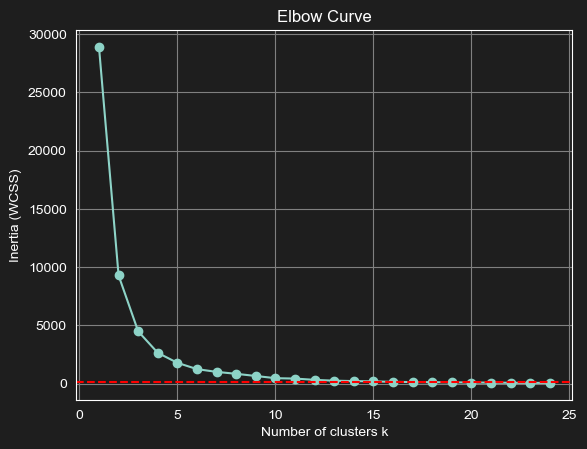

lowest inertia value change: 22


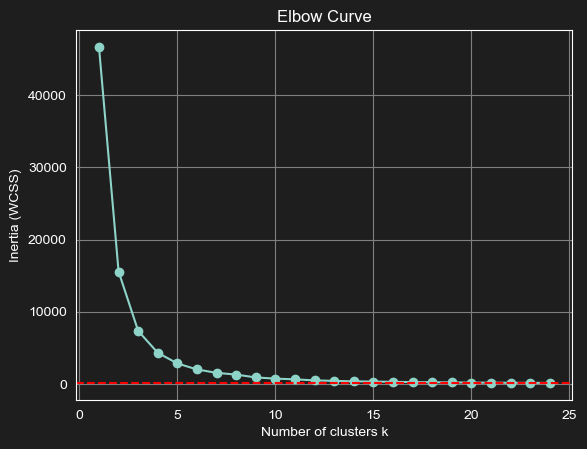

lowest inertia value change: 16


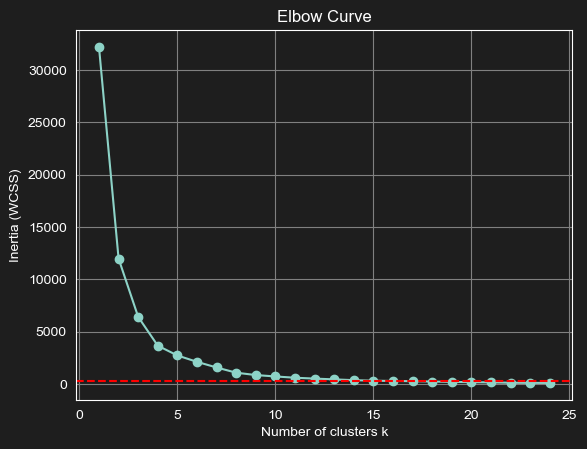

lowest inertia value change: 17


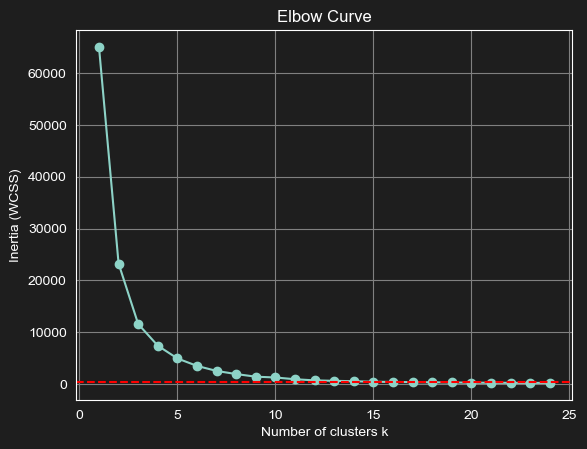

In [87]:
stats = ['avg_target_shot_cr','avg_dribble_success','avg_duels_cr','avg_pass_accuracy']

for stat in stats:
    striker_stats = fit_optimal_kmeans(striker_stats,stat)

# Clustering

In [89]:
# Best Goal Scorers:
striker_stats.sort_values(["avg_target_shot_cr","cluster_avg_target_shot_cr"],ascending= [0,0])[["player_name","n_games","avg_target_shot_cr","std_target_shot_cr","cluster_avg_target_shot_cr"]].head(15)

,player_name,n_games,avg_target_shot_cr,std_target_shot_cr,cluster_avg_target_shot_cr
364,Serhou Guirassy,58,47.586207,43.491807,9
171,Alexander Isak,65,37.512821,42.151474,14
46,Robert Lewandowski,71,35.727700,42.194497,14
543,Ante Budimir,72,35.648148,44.255761,14
28,Luuk de Jong,67,35.497512,42.578918,14
209,Alexander Sørloth,72,35.300926,44.460183,14
324,Chris Wood,67,34.701493,44.890369,14
35,Kylian Mbappé,99,34.360269,35.965550,14
322,Ayoze Pérez,62,33.064516,44.301083,3
104,Alexandre Lacazette,59,32.937853,41.524284,3


In [90]:
striker_stats[striker_stats.cluster_avg_target_shot_cr == 9]

,player_id,player_name,n_games,avg_dribble_success,std_dribble_success,avg_target_shot_cr,std_target_shot_cr,avg_duels_cr,std_duels_cr,avg_pass_accuracy,std_pass_accuracy,cluster_avg_pass_accuracy,cluster_avg_target_shot_cr,cluster_avg_dribble_success,cluster_avg_duels_cr
364,21393,Serhou Guirassy,58,24.913793,36.279753,47.586207,43.491807,50.63199,18.415577,77.706665,10.029325,5,9,14,15


In [91]:
# Best Dribblers:
striker_stats.sort_values(["avg_dribble_success","cluster_avg_dribble_success"],ascending= [0,0])[["player_name","n_games","avg_dribble_success","std_dribble_success","cluster_avg_dribble_success"]].head(20)

,player_name,n_games,avg_dribble_success,std_dribble_success,cluster_avg_dribble_success
1159,Henry Mosquera,57,51.857738,30.645705,20
101,Jérémy Doku,64,51.144831,35.173646,20
167,Moses Simon,54,50.558161,30.666850,20
80,Paulinho,62,50.215054,34.532778,20
1108,Kenan Yıldız,54,49.885362,35.762224,20
346,Eberechi Eze,61,49.550008,30.452032,9
1262,Lamine Yamal,73,49.476002,30.524792,9
1250,Yankuba Minteh,62,48.932063,36.024861,9
377,Rafael Leão,70,48.143785,31.897308,9
727,Derik Lacerda,47,48.049645,44.273959,9


In [92]:
striker_stats[striker_stats.cluster_avg_dribble_success == 20]

,player_id,player_name,n_games,avg_dribble_success,std_dribble_success,avg_target_shot_cr,std_target_shot_cr,avg_duels_cr,std_duels_cr,avg_pass_accuracy,std_pass_accuracy,cluster_avg_pass_accuracy,cluster_avg_target_shot_cr,cluster_avg_dribble_success,cluster_avg_duels_cr
80,987,Paulinho,62,50.215054,34.532778,29.838710,41.831597,45.011072,20.906516,84.773035,7.515955,11,13,20,7
101,1422,Jérémy Doku,64,51.144831,35.173646,7.812500,25.539807,48.640562,25.245109,76.636649,26.415751,5,5,20,15
167,2781,Moses Simon,54,50.558161,30.666850,16.358025,34.793602,44.250778,17.350623,75.623057,11.985077,2,15,20,7
1108,339883,Kenan Yıldız,54,49.885362,35.762224,12.037037,32.118861,50.648629,23.205736,82.072258,14.765685,15,2,20,15
1159,350927,Henry Mosquera,57,51.857738,30.645705,2.631579,14.702565,42.199637,21.685586,78.338753,19.491532,5,16,20,13


In [93]:
striker_stats.sort_values(["avg_duels_cr","cluster_avg_duels_cr"],ascending= [0,0])[["player_name","n_games","avg_duels_cr","std_duels_cr","cluster_avg_duels_cr"]].head(20)

,player_name,n_games,avg_duels_cr,std_duels_cr,cluster_avg_duels_cr
458,Milan Đurić,67,60.986130,22.809794,5
516,Tobias Lauritsen,65,59.612914,15.697598,5
727,Derik Lacerda,47,56.183757,22.734630,9
1262,Lamine Yamal,73,55.038893,17.504645,9
28,Luuk de Jong,67,53.902796,18.850333,9
243,Deyverson,58,53.884131,20.213160,9
425,Nicolò Cambiaghi,56,52.632841,24.138128,9
357,Florian Sotoca,63,52.049234,19.635543,9
668,Ferreira,54,51.950764,28.234210,9
581,Vedat Muriqi,58,51.370173,17.082617,9


In [95]:
striker_stats.sort_values(["avg_pass_accuracy","cluster_avg_pass_accuracy"],ascending= [0,0])[["player_name","n_games","avg_pass_accuracy","std_pass_accuracy","cluster_avg_pass_accuracy"]].head(15)

,player_name,n_games,avg_pass_accuracy,std_pass_accuracy,cluster_avg_pass_accuracy
80,Paulinho,62,84.773035,7.515955,11
19,Heung-min Son,65,84.743458,5.641457,11
310,Iliman Ndiaye,63,84.485700,9.120671,11
256,Rodrygo,68,84.274770,22.102794,11
208,Jonathan David,66,83.094075,9.994756,11
126,Pedro Neto,57,83.076093,18.170627,11
102,Bukayo Saka,60,82.859731,8.506756,11
43,Khvicha Kvaratskhelia,67,82.713524,16.861145,11
847,Florian Wirtz,63,82.494204,8.341682,11
35,Kylian Mbappé,99,82.365391,13.634436,11


In [ ]:
striker_stats[striker_stats.cluster_pass == 4]

In [ ]:
filter_query = 'major_position.isin(["M"])'


# Stat to look at:
stat = 'target_shot_conversion_perc'
agg_fun = "mean"
rank_cutoff = 20

# configs 
min_appearance = 40

dribble_dat_g = complete_data.query(filter_query).reset_index().fillna(0).groupby("player_name").agg(n_apps = ("player_name","size"),stat = (stat,agg_fun)).reset_index()
dribble_dat_g = dribble_dat_g[dribble_dat_g.n_apps >= min_appearance]
dribble_dat_g['rank'] = dribble_dat_g["stat"].fillna(0).rank(ascending= False,method = 'dense')
dribble_dat_g.sort_values("rank",inplace = True)

fig, ax = plt.subplots(figsize=(13, 8))

# Plot correctly, no comma here
sns.boxplot(
    data=complete_data.query(filter_query)[complete_data.query(filter_query).player_name.isin(dribble_dat_g[dribble_dat_g['rank'] < rank_cutoff]['player_name'])],
    x="player_name",
    y=stat,
    order=dribble_dat_g[dribble_dat_g['rank'] < rank_cutoff]['player_name'],
    ax=ax,
    
)

# Now this works correctly on `ax`
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title(f"Stat: {stat}")
plt.tight_layout()
plt.show()


In [ ]:
fig = plt.subplots(nrows=1, ncols = 1, figsize = (20,10))
fig = sns.heatmap(complete_data.query(filter_query)[config['PASSING_COLS']  + ['team_goals_scored','team_non_penalty_goals_scored','team_goals_conceded']].corr(),cmap = 'coolwarm')
fig.set_xticklabels(fig.get_xticklabels(),rotation = 60)


In [ ]:
sns.pairplot(complete_data.query(filter_query)[config['PASSING_COLS']  + ['team_goals_scored','team_non_penalty_goals_scored','team_goals_conceded']])

In [ ]:
complete_data['win'].value_counts(normalize=True)

In [ ]:
filter_query

In [ ]:
# trial multiclass model:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(complete_data.query(filter_query)[list(set(config['PASSING_COLS'] + config['ATTACK_COLS'] ))],
                                                    complete_data.query(filter_query)['win'],
                                                    stratify=complete_data.query(filter_query)['win'],
                                                    random_state=33)


In [ ]:
create_submodel("catboost")

In [ ]:
output_path

In [ ]:
model = run_model_with_fs_tune(X_train, X_test, y_train, y_test,dat_dict,'catboost',output_path=output_path)

In [ ]:
dat = NNDataFromPd(X_train.fillna(0), y_train.outcome_num, dat_dict)
train_loader = DataLoader(dat, batch_size = 128,shuffle= True)

In [ ]:
train_loader.dataset.X_numeric_tensor.shape

In [ ]:
# model params
n_features = X_train.shape[1]
n_classes = y_train.iloc[:,0].nunique()
model = MultiClassModel(n_features,n_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)

In [ ]:
epochs = 500

for epoch in range(epochs):
    
    epoch_loss = 0

    for X_numeric_batch, X_categoric_batch, y_batch in train_loader:
        
        pred = model.forward(X_numeric_batch)
        
        loss = criterion(pred,y_batch)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch: {epoch}, Loss: {epoch_loss}")

In [ ]:
model.eval()

In [ ]:
X_test['passes_accuracy'] = X_test['passes_accuracy'].astype("float64")

In [ ]:
# test sets

test_dat = NNDataFromPd(X_test,y_test,dat_dict)
test_loader = DataLoader(test_dat,batch_size= X_test.shape[0],shuffle=True)

In [ ]:
model.eval()
with torch.no_grad():
    for X_numeric_batch, X_categoric_batch, y_batch in test_loader:
        output = model(X_numeric_batch)
        pred_class = torch.argmax(output, dim = 1)

In [ ]:
# Logistic Model:
X_train, X_test, y_train, y_test = train_test_split(complete_data[complete_data.games_position == 'F'][list(set(config['DEFENSE_COLS'] + config['PASSING_COLS'] + config['ATTACK_COLS'])) + ['win']].drop(columns = 'win'),
                                                    complete_data[complete_data.games_position == 'F']['win'],
                                                    stratify=complete_data['win'],
                                                    random_state=33)

In [ ]:
train_dat = NNDataFromPd(X_train,y_train,dat_dict)
train_loader = DataLoader(train_dat,batch_size= 128,shuffle = True)

In [ ]:
n_features = X_train.shape[1]
model = LogisticNNModelComplex(n_features)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.005)

In [ ]:
epochs = 500
for epoch in range(epochs):
    epoch_loss = 0
    
    for X_numeric, X_categoric, y in train_loader:

        pred = model(X_numeric)

        loss = criterion(pred,y.unsqueeze(1))

        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch},  Loss: {loss}")


In [ ]:
pred_proba.squeeze(1)

In [ ]:
from validations import *


test_dat = NNDataFromPd(X_test,y_test,dat_dict)
test_loader = DataLoader(test_dat,batch_size= X_test.shape[0],shuffle=True)

model.eval()
with torch.no_grad():
    for X_numeric_batch, X_categoric_batch, y_batch in test_loader:
        output = model(X_numeric_batch)
        pred_proba = torch.softmax(output,dim =1)
        pred_class = torch.argmax(output, dim = 1)


discrete_evaluations(y_test,pred_class,pred_proba.squeeze(1),classification_type="Binary",model_path= output_path)

In [ ]:
test_fixtures = get_team_fixtures("Liverpool",2)

In [ ]:
test_fixtures

In [ ]:
player_stat_url = "https://v3.football.api-sports.io/fixtures/players?fixture={}".format(1035045)
fixture_dat = requests.get(player_stat_url,headers=headers_api_sport)

In [ ]:
pd.json_normalize(pd.json_normalize(fixture_dat.json()['response']))['players'][0]

In [ ]:
fixture_dat_expanded = pd.concat([pd.json_normalize(pd.json_normalize(fixture_dat.json()['response'])['players'][0])[['player.id','player.name']],pd.json_normalize(pd.json_normalize(pd.json_normalize(pd.json_normalize(fixture_dat.json()['response'])['players'][0])['statistics']).rename(columns = {0:"player_stats"})['player_stats'])],axis = 1)

In [ ]:
fixtures_stat = complete_data.groupby(['fixture_id','team'],as_index=False).agg(n_opponent = ('opponent','count'),total_passes = ('passes_total','sum')).sort_values('fixture_id',ascending= False)

In [ ]:
fixtures_stat

In [ ]:
complete_data[complete_data.fixture_id == 1376437][['team','opponent']]

In [ ]:
teams_dat[teams_dat.team_name.str.contains("Tels")]

In [ ]:
angers = pd.read_parquet(home_dir + "/data/Fixtures/angers_2024.parquet")

In [ ]:
angers['fixture_date'] = pd.to_datetime(angers['fixture_date'])

In [ ]:
angers['fixture_date']